# Eksperymenty z modelami opisujące profile pacjentów 

Członkowie grupy: 
 * Alicja Miłoszewska [145213]
 * Anna Prałat [145395]
 * Alex Terentowicz [145419]
 * Daniel Zdancewicz [145317]


In [1]:
import pandas as pd
import numpy as np
import os
from typing import NamedTuple, List
from textwrap import wrap
from matplotlib import pyplot as plt
from stable_baselines3 import PPO, A2C, DQN
from sklearn.ensemble import RandomForestClassifier

In [2]:
from environment.profiles import profiles

In [3]:
from environment.fogg_behavioural_model import Patient

## Parametry eksperymentu

In [4]:
UpdatedEveryDayHours = 24
WeekHours = 7 * UpdatedEveryDayHours
ThreeWeeksHours = WeekHours * 3
EightWeeksHours = WeekHours * 8
FiveWeeksHours = WeekHours * 5

Condition = 'stable'
Habituation = False
#very high e.g. 9999999999 to make it outside of the intervention time...effectively no preference shift
TimePreferenceUpdateStep = 9999999999999999
# 500 runs in the paper
RunCount = 50

In [5]:
ResultsDirectory = 'results'
if not os.path.exists(ResultsDirectory):
  os.makedirs(ResultsDirectory)

## Opisy profili
Na podstawie 5 pytań oraz odpowiedzi zagregowanych w tabeli 1 dla poszczególnych profili wyróżniliśmy 4 cechy charakterystyczne, które pozwalają zamodelować różnice pomiędzy profilami i nadać im nazwy. Są to:

  * responsiveness - cecha agregująca pytania 4 i 5, dotyczy gotowości pacjenta do wykonania zaleconej przez system aktywności. Przyjmuje ona wartości z zakresu [-2, 0] i jest obliczana na podstawie wartości cech "stress" oraz "tiredness". Wartość "stress" jest obliczana jako różnica "arousal" oraz "valence", gdzie zgodnie z Markov et al. (2019) w "arousal-valence emotion space" stres jest tym większy, im większa wartość "arousal" i im mniejsza wartość "valence". Wartość "tiredness" bierze pod uwagę 2 czynniki: liczbę przespanych godzin w nocy oraz ile godzin pacjent jest na nogach.
 * motivation - dotyczy sytuacji, gdy pacjent lubi pokonywać swój własny rekord. Przyjmuje wartości z zakresu [0,1] i śledzi ostatnie 10 reakcji na powiadomienia o aktywności. Im więcej razy pacjent pozytywnie zareagował na powiadomienie, tym bardziej ma ochotę nie popsuć swojej dobrej passy. Wykorzystaliśmy do tego metodę _update_patients_activity_score().

 
Trudniejsze do zamodelowania okazały się cechy "peer_competition" oraz "peer_comparison" ze względu na konieczność symulacji zachowania grupy rówieśników, a nie tylko jednego pacjenta:

 * peer_competition - wartości losowane ze zbioru {0,1}, poza sytuacją, gdy pacjent jest w domu i nie ma kontaktu z rówieśnikami.
 * peer_comparison - cecha modelująca sytuację, w której pacjent czuje się lepiej, gdy jest lepszy od rówieśników, losowana podczas każdego kroku algorytmu ze zbioru {0,1}.

### Profil 0 - Indifferent:
Pacjenci z tej grupy nie wykazują entuzjazmu zarówno w aspekcie samodoskonalenia, jak i rywalizacji społecznej, wskazując na preferowanie samodzielnych działań bez zewnętrznych nacisków. Z drugiej strony nie wpływa na nich negatywnie stres oraz zmęczenie. Na tle wyróżnionych charakterystyk nie przyjmują żadnych skrajnych wartości.

### Profil 1 - Stressed:
Pacjenci ci nie reagują dobrze na interwencje w stresujących momentach, co sugeruje, że ich interakcje powinny być zaplanowane w chwilach spokoju. Będą oni tracić chęć odpowiedzi na powiadomienia zarówno w sytuacji, gdy są zmęczeni, jak i wtedy, kiedy są zestresowani. To ich odróżnia od profilu zerowego. Ta cecha jest zamodelowana poprzez odjęcie wartości maksymalnej z cech *stress* oraz *tiredness* -> max(*stress*, *tiredness*).

### Profil 2 - Motivated:
Na motywację tej grupy pacjentów wpływają zarówno pozytywne, jak i negatywne bodźce. Jest zmotywowana widocznymi postępami i osiągnięciami, korzysta z funkcji, które śledzą i wyświetlają ich postępy zdrowotne oraz zwiększają ich zaangażowanie poprzez namacalne wyniki (cecha motivation). Algorytm uczenia agenta odbiera to jako dodatkowe punkty z wartości *peer_competition*, *peer_comparison* oraz *motivation* przy obliczaniu zachowania na podstawie modelu Fogga. W tym samym czasie ci pacjenci mogą tracić "punkty" ze względu na stres i zmęczenie, podobnie jak pacjenci z profilu pierwszego.

### Profil 3 Responsive:
Ta grupa pacjentów powinna najlepiej się odnaleźć w środowisku adaptacyjnych interwencji. Ich własny postęp jest dla nich motywacją (cecha motivation). Mogą oni też czerpać zyski z rywalizacji z innymi. Wpływ stresu nie jest aż tak wyraźny w ich przypadku. Mimo wszystko algorytm musi brać pod uwagę, że nie będą dobrze odpowiadać na powiadomienia w sytuacji, gdy są zmęczeni. Aby odzwierciedlić neutralną odpowiedź na pytania 1, 3 oraz 4, przemnożono odpowiadające tym pytaniom cechy (Q1 - *self.peer_comparison*, Q3 - *self.peer_competition*, Q4 - *self.tiredness*) przez 0.5.



## Metody przedstawienia wyników

In [6]:

class ExperimentResult(NamedTuple):
  sleep_hours: List[float]
  positive_mood_hours: List[float]
  response_ratios: List[float]
  notifications: List[float]


In [7]:
from typing import Dict

def plot_experiment_result_hours(result: ExperimentResult):
  (sleeps_hours, positive_moods_hours, _, _) = result

  plt.figure(figsize=(8, 5))
  plt.plot(np.nanmean(sleeps_hours, axis=0), label='Hours slept', color='r')
  plt.plot(np.mean(positive_moods_hours, axis=0), label='Hours in positive mood')
  plt.ylabel('Hours ')
  plt.xlabel('Intervention Days')
  plt.legend()
  plt.show()

def plot_experiment_result_ratios(result: ExperimentResult):
  (_, _, ratios, notifications) = result

  _, (ratios_axis, notifications_axis) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 8))
  ratios_axis.plot(np.nanmean(ratios, axis=0), label='response ratio', color='r')
  notifications_axis.plot(np.nanmean(notifications, axis=0), label='num of notifications')
  notifications_axis.set_xlabel('Intervention days')
  notifications_axis.set_ylabel('No. of notifications')
  ratios_axis.set_ylabel('Response ratio')
  plt.show()

class ReadResult(NamedTuple):
  ratios: List[float]
  notifications: List[float]

def read_ratios_and_notifications(name: str, epoch_count: int = RunCount, condition: str = Condition) -> ReadResult:
  ratios = []
  notifications = []

  no_activity_count = 0
  for epoch in range(epoch_count):
    frame = pd.read_csv(f"{ResultsDirectory}/patient1_{condition}_{name}_run{epoch}.csv")
    has_performed_activity = any(frame['activity performed'].values)

    if has_performed_activity:
      ratios.append(frame.response_ratio)
      notifications.append(frame.notifications)
    else:
      no_activity_count += 1

  print(f" {no_activity_count} out of {epoch_count} runs had no activity performed throughout the full intervention.")
  return ReadResult(ratios, notifications)

def plot_experiment_results_ratio(label: str, not_random_result: ReadResult, result_map: Dict[str, ReadResult]):
  figure: plt.Figure
  figure, (ratios_axis, notifications_axis) = plt.subplots(2, 1, sharex=True, sharey=False, figsize=(10, 10))
  figure.suptitle(f'profile "{label}": Comparison of prompt learning strategies', fontsize=20)
  figure.subplots_adjust(top=0.9)

  for label, (ratios, notifications) in result_map.items():
    ratios_axis.plot(np.nanmean(ratios, axis=0), label=label)
    notifications_axis.plot(np.nanmean(notifications, axis=0), label=label)

  notifications_axis.plot(
    np.ones(len(np.mean(not_random_result.notifications, axis=0)) + 2),
    label='Preferred number of notifications a day'
  )
  notifications_axis.set_xlabel('Intervention Days', fontsize=16)
  notifications_axis.set_ylabel('\n'.join(wrap('Numbers of notifications', 20)), fontsize=16)
  ratios_axis.set_ylabel('\n'.join(wrap('Activity performed to prompt ratio', 20)))
  notifications_axis.legend(fontsize=13)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()


## Experiment methods

### No intervention

In [8]:

from typing import Type

def run_no_intervention_experiment(Profile: Type[Patient], epoch_count: int = RunCount) -> ExperimentResult:
  sleep_hours = []
  positive_hours = []
  ratios = []
  notifications = []

  for _ in range(epoch_count):
    environment = Profile(
      behaviour_threshold=20,
      habituation=Habituation,
      time_preference_update_step=TimePreferenceUpdateStep
    )

    for _ in range(EightWeeksHours):
      observation, reward, done, _, info = environment.step(0)

    sleep_hours.append(environment.h_slept)
    positive_hours.append(environment.h_positive)
    ratios.append(environment.rr)
    notifications.append(environment.num_notified)

  return ExperimentResult(sleep_hours, positive_hours, ratios, notifications)


### Intervention

In [9]:
from typing import Callable

def save_epoch_to_csv(environment: Patient, condition: str, name: str, epoch: int):
  df = pd.DataFrame()
  df['response_ratio'] = environment.rr
  df['activity performed'] = environment.num_performed
  df['notifications'] = environment.num_notified
  df['sleep'] = environment.h_slept
  df['positive'] = environment.h_positive
  df['non_stationary'] = environment.h_nonstationary
  df.to_csv(f"{ResultsDirectory}/patient1_{condition}_{name}_run{epoch}.csv")

Method = Callable[[Patient], Patient]
def run_intervention_experiment(Patient: Type[Patient], method: Method, name: str, epoch_count=RunCount, condition=Condition):
  ratios = []
  notifications = []

  sleep_hours = []
  positive_mood_hours = []
  times_performed = 0

  for epoch in range(epoch_count):
    environment = method(
      Patient(
        behaviour_threshold=20,
        habituation=Habituation,
        time_preference_update_step=TimePreferenceUpdateStep
      )
    )

    if any(environment.num_performed): times_performed += 1

    save_epoch_to_csv(environment, condition, name, epoch)

    ratios.append(environment.rr)
    notifications.append(environment.num_notified)
    sleep_hours.append(environment.h_slept)
    positive_mood_hours.append(environment.h_positive)

  print("These figures include runs in which no prompt resulted in the activity being performed.")
  print(f"{times_performed} out of {epoch_count} resulted in activity being performed.")

  return ExperimentResult(sleep_hours, positive_mood_hours, ratios, notifications)


### Heuristic

Notify every hour except in night and when the patient is alseep

In [10]:
def always_notify(environment: Patient, intervention_length: int = EightWeeksHours) -> Patient:
  action = 0

  for _ in range(intervention_length):
    observation, _, _, _, _ = environment.step(action)
    # 9-th is the time of the day
    # 3 is the night
    if observation[9] == 3 or observation[3] == 1:
      action = 0
    else:
      action = 1

  return environment

### Random 
Randomly sample during the day skip the nights

In [11]:
def random_notification(environment: Patient, intervention_length: int = EightWeeksHours) -> Patient:
  action = 0
  for i in range(intervention_length):

    observation, _, _, _, _ = environment.step(action)
    # 9-th is the time of the day
    if observation[9] == 3:
      action = 0
    else:
      action = environment.action_space.sample()

  return environment

### Supervised Learning

#### Static model

In [12]:
def supervised_after_three_weeks(environment: Patient) -> Patient:
  environment = always_notify(environment, intervention_length=ThreeWeeksHours)
  classifier = RandomForestClassifier(class_weight='balanced')
  classifier.fit(environment.observation_list, environment.activity_performed)

  remaining_time = EightWeeksHours - ThreeWeeksHours
  observation = environment._get_current_state()

  for _ in range(remaining_time):
    # applying supervised model
    action = classifier.predict(np.array([observation]))[0]
    observation, _, _, _, _ = environment.step(action)

  return environment

### Adaptive model 

In [13]:
def supervised_adaptive_after_three_weeks(environment: Patient) -> Patient:
  environment = always_notify(environment, intervention_length=ThreeWeeksHours)
  classifier = RandomForestClassifier(class_weight='balanced')
  classifier.fit(environment.observation_list, environment.activity_performed)

  remaining_time = EightWeeksHours - ThreeWeeksHours
  observation = environment._get_current_state()
  samples = len(environment.observation_list)

  for _ in range(remaining_time):
    # applying supervised model
    action = classifier.predict(np.array([observation]))[0]
    observation, _, _, _, _ = environment.step(action)

    if len(environment.observation_list) <= samples: continue
    # retrain when new samples are provided
    classifier = RandomForestClassifier(class_weight='balanced')
    classifier.fit(environment.observation_list, environment.activity_performed)
    samples = len(environment.observation_list)

  return environment

### Deep Q Network

In [14]:
def dqn(environment: Patient) -> Patient:
  model = DQN("MlpPolicy", environment, verbose=0, learning_starts=UpdatedEveryDayHours)
  model.learn(total_timesteps=EightWeeksHours)
  return environment

### Proximal Policy Optimisation

In [15]:
def ppo(environment: Patient) -> Patient:
  model = PPO("MlpPolicy", environment, verbose=0, n_steps=UpdatedEveryDayHours, batch_size=UpdatedEveryDayHours)
  model.learn(total_timesteps=EightWeeksHours)
  return environment

### Advantage Actor Critic

In [16]:
def a2c(environment: Patient) -> Patient:
  model = A2C("MlpPolicy", environment, verbose=0, n_steps=UpdatedEveryDayHours)
  model.learn(total_timesteps=EightWeeksHours)
  return environment

### Comparison between prompt learning strategies

Running experiment for profile: 'Indifferent'
	Running experiments...
	 - no intervention


	 - heuristic
These figures include runs in which no prompt resulted in the activity being performed.
36 out of 50 resulted in activity being performed.
	 - random
These figures include runs in which no prompt resulted in the activity being performed.
41 out of 50 resulted in activity being performed.
	 - supervised learning
These figures include runs in which no prompt resulted in the activity being performed.
22 out of 50 resulted in activity being performed.
	 - adaptive supervised learning
These figures include runs in which no prompt resulted in the activity being performed.
21 out of 50 resulted in activity being performed.
	 - dqn
These figures include runs in which no prompt resulted in the activity being performed.
36 out of 50 resulted in activity being performed.
	 - ppo
These figures include runs in which no prompt resulted in the activity being performed.
34 out of 50 resulted in activity being performed.
	 - a2c
These figures include runs in which no prompt resulted in th

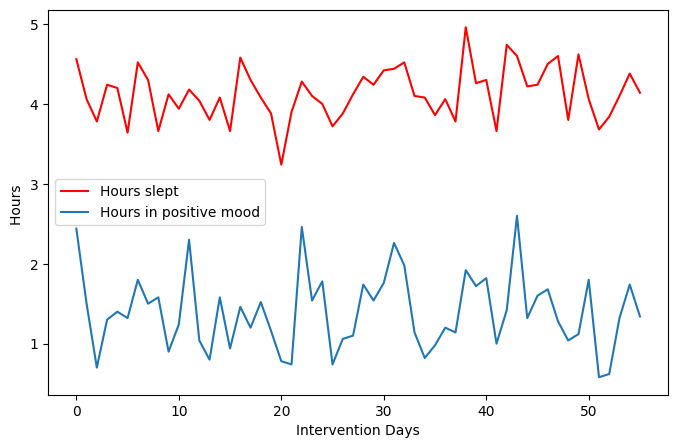

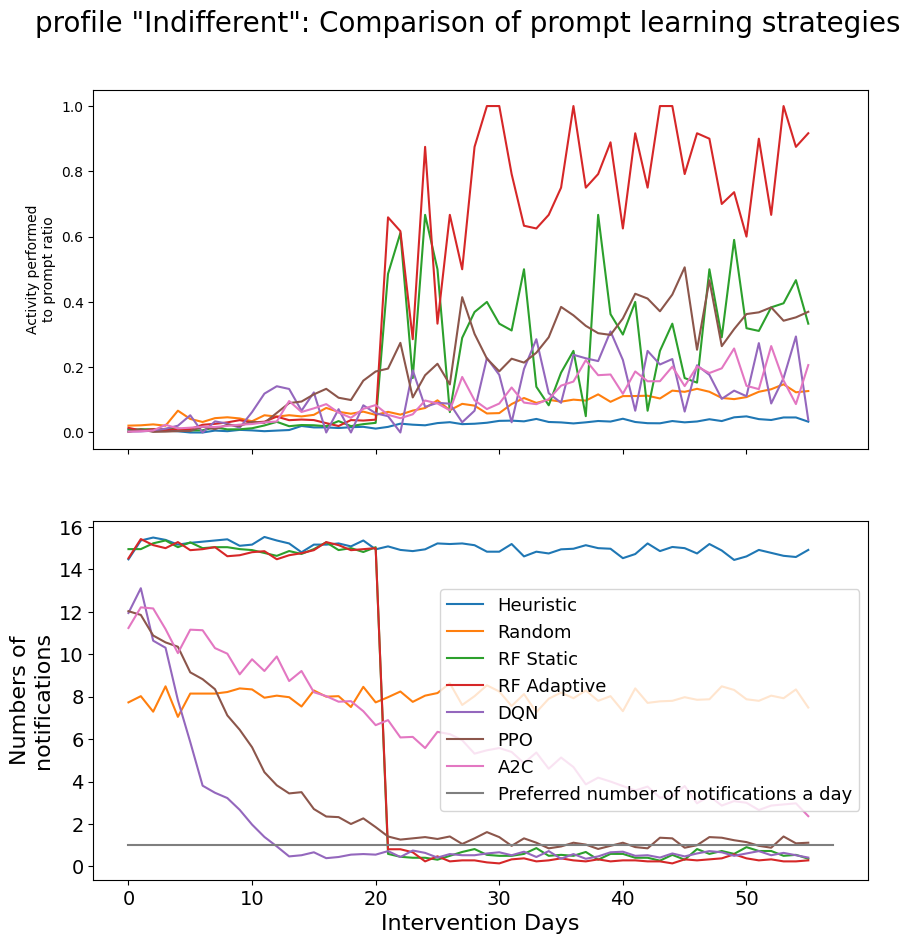


Running experiment for profile: 'Stressed'
	Running experiments...
	 - no intervention
	 - heuristic
These figures include runs in which no prompt resulted in the activity being performed.
41 out of 50 resulted in activity being performed.
	 - random
These figures include runs in which no prompt resulted in the activity being performed.
35 out of 50 resulted in activity being performed.
	 - supervised learning
These figures include runs in which no prompt resulted in the activity being performed.
22 out of 50 resulted in activity being performed.
	 - adaptive supervised learning
These figures include runs in which no prompt resulted in the activity being performed.
21 out of 50 resulted in activity being performed.
	 - dqn
These figures include runs in which no prompt resulted in the activity being performed.
32 out of 50 resulted in activity being performed.
	 - ppo
These figures include runs in which no prompt resulted in the activity being performed.
32 out of 50 resulted in activi

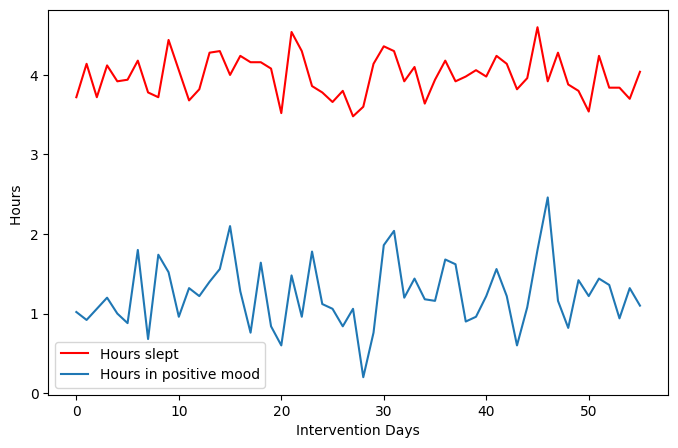

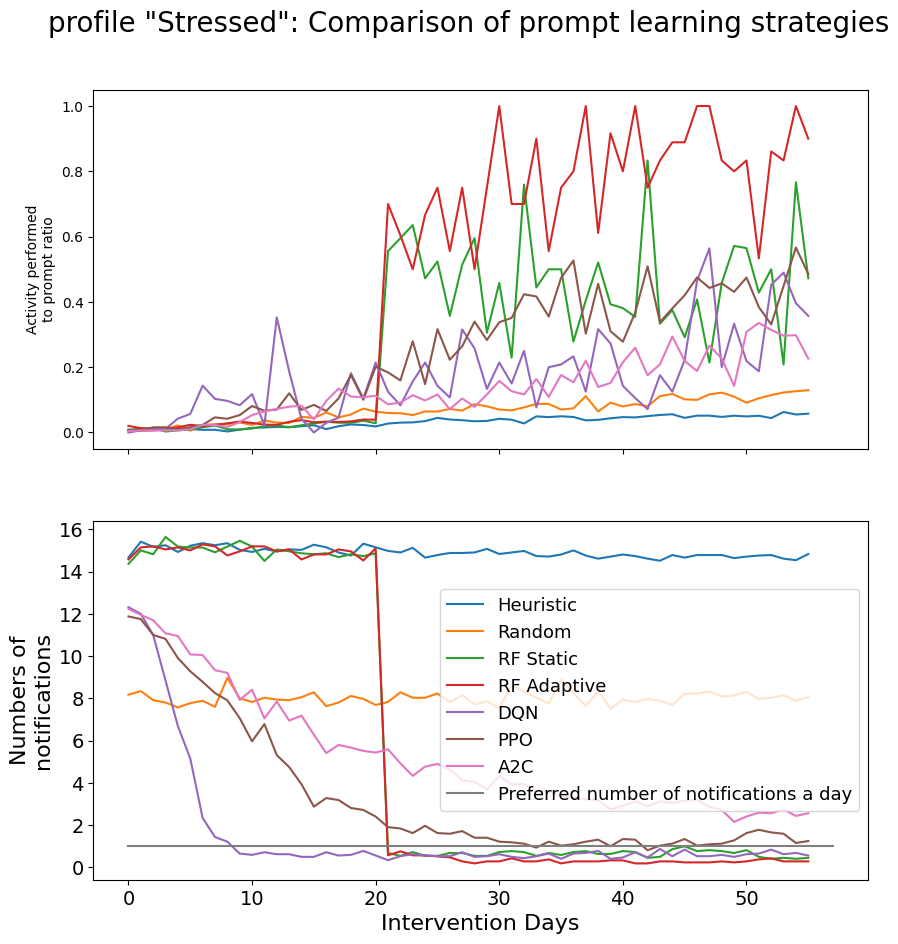


Running experiment for profile: 'Motivated'
	Running experiments...
	 - no intervention
	 - heuristic
These figures include runs in which no prompt resulted in the activity being performed.
33 out of 50 resulted in activity being performed.
	 - random
These figures include runs in which no prompt resulted in the activity being performed.
41 out of 50 resulted in activity being performed.
	 - supervised learning
These figures include runs in which no prompt resulted in the activity being performed.
26 out of 50 resulted in activity being performed.
	 - adaptive supervised learning
These figures include runs in which no prompt resulted in the activity being performed.
21 out of 50 resulted in activity being performed.
	 - dqn
These figures include runs in which no prompt resulted in the activity being performed.
32 out of 50 resulted in activity being performed.
	 - ppo
These figures include runs in which no prompt resulted in the activity being performed.
28 out of 50 resulted in activ

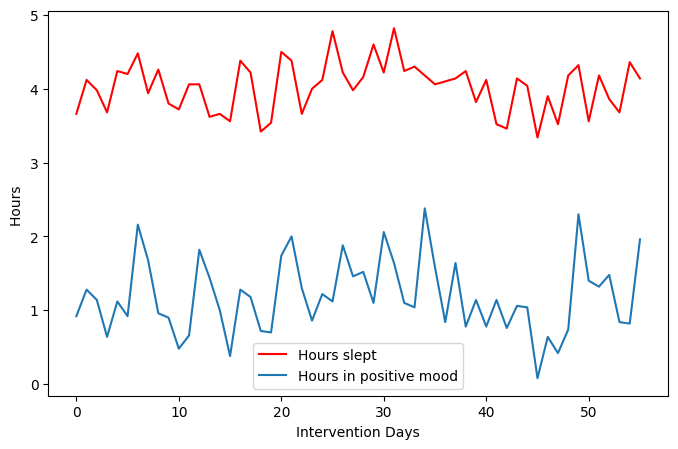

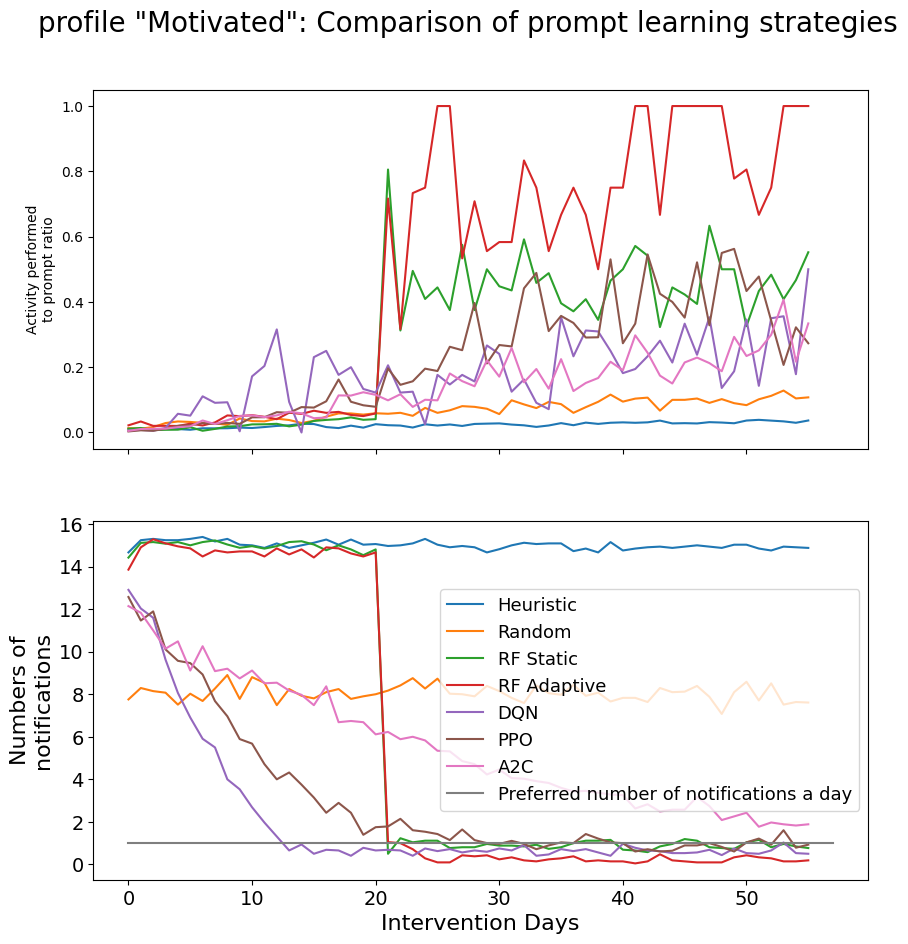


Running experiment for profile: 'Responsive'
	Running experiments...
	 - no intervention
	 - heuristic
These figures include runs in which no prompt resulted in the activity being performed.
33 out of 50 resulted in activity being performed.
	 - random
These figures include runs in which no prompt resulted in the activity being performed.
41 out of 50 resulted in activity being performed.
	 - supervised learning
These figures include runs in which no prompt resulted in the activity being performed.
27 out of 50 resulted in activity being performed.
	 - adaptive supervised learning
These figures include runs in which no prompt resulted in the activity being performed.
26 out of 50 resulted in activity being performed.
	 - dqn
These figures include runs in which no prompt resulted in the activity being performed.
32 out of 50 resulted in activity being performed.
	 - ppo
These figures include runs in which no prompt resulted in the activity being performed.
33 out of 50 resulted in acti

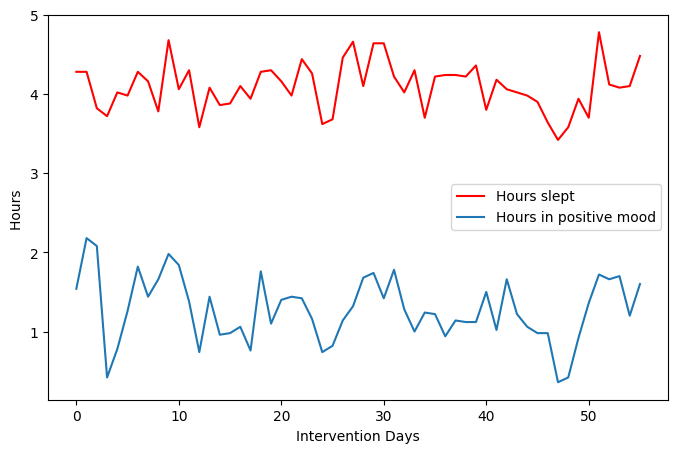

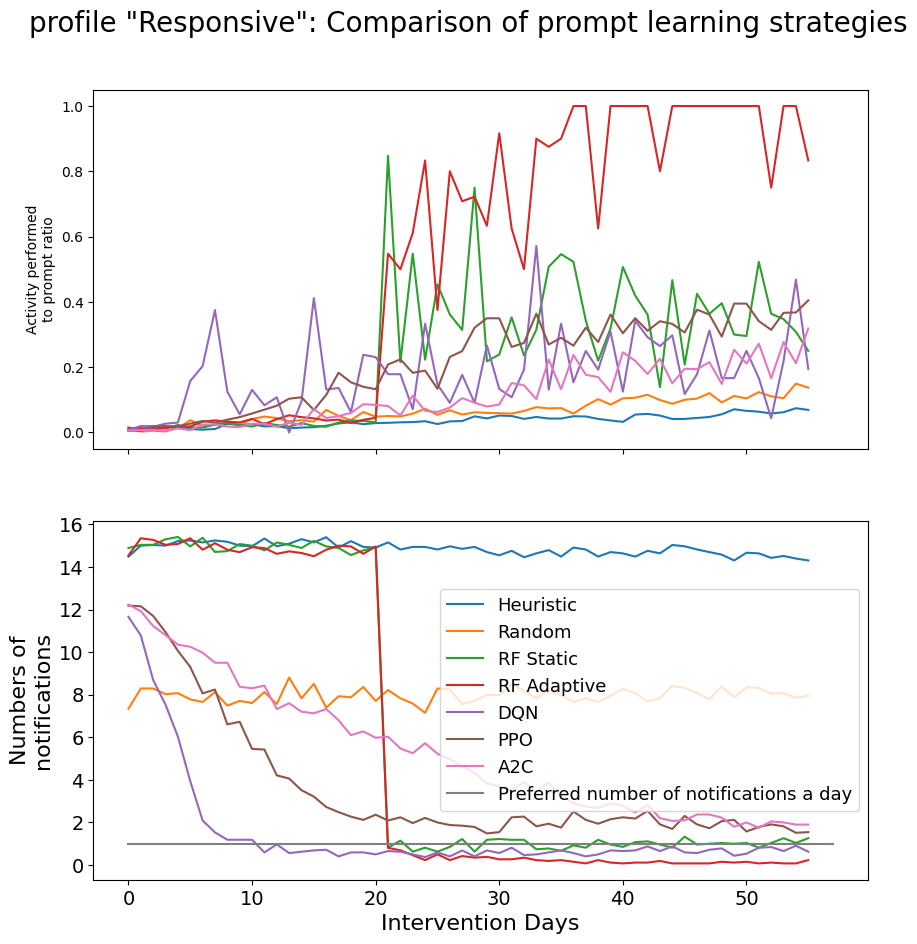

In [17]:
def run_experiment_for_profile(Profile: Type[Patient], label: str):
  print("\tRunning experiments...")
  print("\t - no intervention")
  result = run_no_intervention_experiment(Profile)
  print("\t - heuristic")
  run_intervention_experiment(Profile, always_notify, f'h-{label}')
  print("\t - random")
  run_intervention_experiment(Profile, random_notification, f'random-{label}')
  print("\t - supervised learning")
  run_intervention_experiment(Profile, supervised_after_three_weeks, f'static_sup3-{label}')
  print("\t - adaptive supervised learning")
  run_intervention_experiment(Profile, supervised_adaptive_after_three_weeks, f'adaptive_sup3-{label}')
  print("\t - dqn")
  run_intervention_experiment(Profile, dqn, f'dqn-{label}')
  print("\t - ppo")
  run_intervention_experiment(Profile, ppo, f'ppo-{label}')
  print("\t - a2c")
  run_intervention_experiment(Profile, a2c, f'a2c-{label}')
  print("\tDone.")

  always_notify_result = read_ratios_and_notifications(f'h-{label}')
  random_result = read_ratios_and_notifications(f'random-{label}')
  static_sup3_result = read_ratios_and_notifications(f'static_sup3-{label}')
  adaptive_sup3_result = read_ratios_and_notifications(f'adaptive_sup3-{label}')
  dqn_result = read_ratios_and_notifications(f'dqn-{label}')
  ppo_result = read_ratios_and_notifications(f'ppo-{label}')
  a2c_result = read_ratios_and_notifications(f'a2c-{label}')

  plot_experiment_result_hours(result)
  plot_experiment_results_ratio(label, random_result, {
    'Heuristic': always_notify_result,
    'Random': random_result,
    'RF Static': static_sup3_result,
    'RF Adaptive': adaptive_sup3_result,
    'DQN': dqn_result,
    'PPO': ppo_result,
    'A2C': a2c_result
  })

for (label, Profile) in profiles.items():
  print(f"Running experiment for profile: '{label}'")
  run_experiment_for_profile(Profile, label)
  print()
  

## Wnioski

Porównując wykresy dla 4 zamodelowanych profilów pacjenta, można zauważyć, że dla każdego z nich najlepiej sobie radził algorytm RF Adaptive osiągając najwyższy stosunek wykonywach aktywności do powiadomień (serie danych oznaczone kolorem czerwonym). Największe różnice w wartościach tego stosunku występują dla algorytmów RF Static oraz Proximal Policy Optimisation po 20 dniu interwencji zmieniając się w zakresie od 0.2 do 0.6. Trudno jednak przypisać te zmiany zależnościom wynikającym z różnic pomiędzy profilami.

Z kolei dla RF Adaptive widać, że w końcowych dniach używania aplikacji dla profili 2 oraz 3 metoda radzi sobie z wysyłaniem powiadomień w odpowiednim czasie, co skutkuje bardzo wysokim stosunkiem wykonywania aktywności do powiadomień. Miejscami był on równy 1. Potwierdza to nasze spostrzeżenia opisami profili, gdyż pacjenci z grupy 2 i 3 mieli więcej cech, które pozwalały im pozostać zmotywowanymi do pracy nad sobą i swoim samopoczuciem.
Ciekawym spostrzeżeniem może być także fakt, że algorytm ma trudności przewidzieć zachowanie pacjentów z grupy 1, którzy niechętnie odpowiadają na powiadomienia, gdy są zmęczeni albo zestresowani. Objawia się to bardzo dużymi i gwałtownymi skokami w stosunku wykonywanych aktywności do powiadomień.

Patrząc na algorytmy Random oraz A2C częste wysyłanie wiadomości, powyżej 3 dziennie, nie wpływa pozytywnie na responsywność pacjentów niezależnie od ich profilu. Pacjenci mogą się wtedy czuć zniechęceni i nie odpowiadać na propozycje aktywności. Pozytywne efekty otrzymujemy, dopiero gdy liczba powiadomień nie przekracza 3 dziennie.
Najlepsze wyniki osiągał algorytm RF Adaptive, zachowując wysoką responsywność przy liczbie powiadomień poniżej 2, a po około 10 dniach schodząc do nawet do okolicy 0 powiadomień dziennie. To znaczy, że już po miesiącu eksperymentu pacjent wykazuje wytworzenie pozytywnego mechanizmu/przyzwyczajenia bez potrzeby aplikacji.